In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.PILToTensor(),
])
test = torchvision.datasets.MNIST(root='./data', train=False, download=True,  transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 97064899.28it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 6688884.25it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32080840.70it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17541923.36it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
ds_test = torch.utils.data.DataLoader(test, batch_size=64)

In [ ]:
from torch import nn
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 1000),
            nn.ReLU(),
            nn.Linear(1000, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1000),
            nn.ReLU(),
            nn.Linear(1000, 28*28),
            nn.Sigmoid()
        )

    def forward(self, flat):
        return self.model(flat)

class AutoencoderBig(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 28*28),
            nn.Sigmoid()
        )

    def forward(self, flat):
        return self.model(flat)

# model = Autoencoder()

In [ ]:
@torch.no_grad()
def valid_loss(model, ds_test, loss_fn, device="cuda"):
    summed_loss = 0
    iters = 0
    for batch in ds_test:
        image_tensor = batch[0]
        B, C, H, W = image_tensor.shape
        inputs = image_tensor.view(B, -1)
        inputs = inputs.to(device)
        inputs = inputs.to(torch.float32)
        inputs /= 255.0

        # 1. forward pass
        outputs = model(inputs)

        # 2. update weights
        loss = loss_fn(outputs, inputs)
        summed_loss += loss.detach().cpu().item()
        iters +=1
    return summed_loss / iters


def _train(model, ds, device="cpu", iterations=None, epochs=1000):
    device = "cuda"
    loss_fn = nn.MSELoss()
    optim = torch.optim.AdamW(model.parameters())
    model.to(device)
    model.train()
    losses = []
    iteration = 0

    for epoch in range(epochs):
        for i, batch in enumerate(ds):
            if iterations is not None and iteration > iterations:
                break

            # 0. process data
            image_tensor = batch[0]
            B, C, H, W = image_tensor.shape
            inputs = image_tensor.view(B, -1) # flatten, but not batches
            inputs = inputs.to(device)
            inputs = inputs.to(torch.float32)
            inputs /= 255.0

            # 1. forward pass
            outputs = model(inputs)

            # 2. update weights
            loss = loss_fn(outputs, inputs)
            optim.zero_grad()
            loss.backward()
            optim.step()

            # 3. log out the losses
            losses.append((iteration, loss.detach().cpu().item()))
            iteration +=1
        valid = valid_loss(model, ds_test, loss_fn, device)
        print(epoch, "train", losses[-1][1], "validation", valid)

    return losses

In [ ]:
def tensor_to_image(image):
    image *= 255
    image = image.to(torch.uint8)
    return Image.fromarray(image.detach().cpu().numpy()).resize((256, 256))

def check(image_tensor, device="cuda"):
    C, H, W = image_tensor.shape
    B = 1
    inputs = image_tensor.view(B, -1) # flatten, but not batches
    inputs = inputs.to(device)
    inputs = inputs.to(torch.float32)
    inputs /= 255.0

    outputs = model(inputs)
    return tensor_to_image(outputs.view(H, W))

In [ ]:
from sklearn.cluster import MiniBatchKMeans
import torch
import tqdm


class QuantizedParams(torch.nn.Module):
    def __init__(self, indexes, codebook):
        super().__init__()
        self.indexes = torch.nn.Parameter(indexes, requires_grad=False)
        self.codebook = torch.nn.Parameter(codebook, requires_grad=False)

    def forward(self):
        return self.codebook[self.indexes.to(torch.int32)]


class RegularParams(torch.nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.weights = torch.nn.Parameter(weights, requires_grad=False)

    def forward(self):
        return self.weights


class HybridLinear(torch.nn.Module):
    def __init__(self, q_w, q_b):
        """each are callable modules that return the weights and biases"""
        super().__init__()
        self.weight = q_w
        self.bias = q_b

    def forward(self, X):
        return X @ self.weight().T + self.bias()


def k_means(X, k=2):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=0, n_init="auto").fit(X)
    return kmeans.cluster_centers_, kmeans.labels_


def quantize(weights, k=2, dtype=torch.float32):
    centroids, labels = k_means(weights.reshape(-1, 1), k)
    codebook = torch.tensor(centroids, dtype=dtype).reshape(-1)
    new_weights = torch.tensor(labels, dtype=torch.uint8).reshape(weights.shape)
    return codebook, new_weights


@torch.no_grad()
def quantize_linear_layer(layer, bits=8, dtype=torch.float32):
    weight = layer.weight
    bias = layer.bias

    num_weights = weight.view(-1, 1).shape[0]
    num_biases = 1 if bias is None else bias.view(-1, 1).shape[0]

    # apply k-means if there are enough parameters
    total_bits = int(2**bits)
    new_weight = None
    new_bias = None
    if num_weights > total_bits:
        w_codebook, w_indexes = quantize(weight, total_bits, dtype)
        new_weight = QuantizedParams(w_indexes, w_codebook)
    else:
        # no quantization :(
        new_weight = RegularParams(weight)

    if bias is not None and num_biases > total_bits:
        b_codebook, b_indexes = quantize(bias, total_bits, dtype)
        new_bias = QuantizedParams(b_indexes, b_codebook)
    else:
        # no quantization :(
        new_bias = RegularParams(
            bias if bias is not None else torch.tensor(0.0, dtype=dtype)
        )

    return HybridLinear(new_weight, new_bias)

def traverse_named_modules(m, filter="Linear"):
    for name, l in m.named_modules():
        if type(l).__name__ == filter:
            sep_name = name.split(".")
            parent = ".".join(sep_name[:-1])
            child = sep_name[-1]
            yield parent, child, l


def traverse_named_modules(m, filter="Linear"):
    for name, l in m.named_modules():
        if type(l).__name__ == filter:
            sep_name = name.split(".")
            parent = ".".join(sep_name[:-1])
            child = sep_name[-1]
            yield parent, child, l


def replace(model, filter, callback):
    modules = list(traverse_named_modules(model, filter))
    for p, c, l in tqdm.tqdm(modules, total=len(modules)):
        setattr(model.get_submodule(p), c, callback(p, c, l))


def replace_linear_with_quantized(model, bits=8, dtype=torch.float16):
    replace(
        model,
        "Linear",
        lambda p, c, l: quantize_linear_layer(l, bits=bits, dtype=dtype),
    )

In [ ]:
big = True
if big:
    model = AutoencoderBig()
    model.load_state_dict(torch.load("ae-big.pth"))
else:
    model = Autoencoder()
    model.load_state_dict(torch.load("ae-1.pth"))

In [ ]:
model = Autoencoder()

In [ ]:
replace_linear_with_quantized(model, bits=8, dtype=torch.float32)

100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


In [ ]:
model.state_dict()

OrderedDict([('model.0.weight.indexes',
              tensor([[ 99, 176,  64,  ...,   9,   8,  62],
                      [ 75,  77, 226,  ..., 213, 190,  96],
                      [167, 109, 135,  ...,  47, 134, 223],
                      ...,
                      [128, 105, 189,  ...,  40,   6,  77],
                      [197,   9,  64,  ..., 121, 229, 129],
                      [239, 243, 101,  ..., 182, 239, 214]], dtype=torch.uint8)),
             ('model.0.weight.codebook',
              tensor([-7.2621e-03,  2.3163e-02, -2.4537e-02,  6.5427e-03,  3.2697e-02,
                      -3.2733e-02, -1.4953e-02,  1.5024e-02, -1.2421e-03, -1.5231e-02,
                       2.7866e-02,  2.9958e-03, -2.9604e-02,  1.0996e-02, -1.2505e-02,
                       1.8854e-02, -4.9734e-03, -1.8026e-02, -3.5566e-02, -1.0201e-02,
                       3.0018e-02,  2.5374e-02, -2.6596e-02,  7.9431e-03, -2.2758e-02,
                       5.7170e-04,  3.4771e-02,  1.2815e-02,  2.0860e-02,  

In [ ]:
model.to("cuda")

AutoencoderBig(
  (model): Sequential(
    (0): HybridLinear(
      (weight): QuantizedParams()
      (bias): QuantizedParams()
    )
    (1): ReLU()
    (2): HybridLinear(
      (weight): QuantizedParams()
      (bias): QuantizedParams()
    )
    (3): ReLU()
    (4): HybridLinear(
      (weight): QuantizedParams()
      (bias): QuantizedParams()
    )
    (5): ReLU()
    (6): HybridLinear(
      (weight): QuantizedParams()
      (bias): RegularParams()
    )
    (7): ReLU()
    (8): HybridLinear(
      (weight): QuantizedParams()
      (bias): QuantizedParams()
    )
    (9): ReLU()
    (10): HybridLinear(
      (weight): QuantizedParams()
      (bias): QuantizedParams()
    )
    (11): ReLU()
    (12): HybridLinear(
      (weight): QuantizedParams()
      (bias): QuantizedParams()
    )
    (13): ReLU()
    (14): HybridLinear(
      (weight): QuantizedParams()
      (bias): QuantizedParams()
    )
    (15): Sigmoid()
  )
)

In [ ]:
valid_loss(model, ds_test, torch.nn.MSELoss())

0.01229883701344774

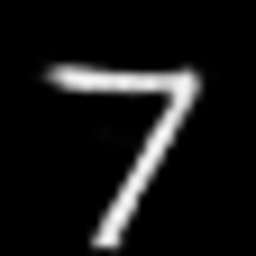

In [ ]:
first = test[0][0]
check(first)

In [ ]:
torch.save(model.state_dict(), "ae-big-q8.pth")

In [ ]:
%shell ls -hla

total 50M
drwxr-xr-x 1 root root 4.0K Aug 22 22:37 .
drwxr-xr-x 1 root root 4.0K Aug 22 22:25 ..
-rw-r--r-- 1 root root 8.2M Aug 22 22:26 ae-1.pth
-rw-r--r-- 1 root root  34M Aug 22 22:36 ae-big.pth
-rw-r--r-- 1 root root 8.4M Aug 22 22:37 ae-big-q8.pth
drwxr-xr-x 4 root root 4.0K Aug 21 13:33 .config
drwxr-xr-x 3 root root 4.0K Aug 22 22:26 data
drwxr-xr-x 1 root root 4.0K Aug 21 13:34 sample_data
